# 3.3.1. Optimizing gradient computation in a noisy setting

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 1000
dev = qml.device("default.qubit", wires=2, shots=N)

@qml.qnode(dev, max_diff=2)
def circuit(x):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.SingleExcitation(x, wires=[0, 1])
    H = qml.PauliX(0) @ qml.PauliX(1)
    return qml.expval(H)

In [3]:
def cost_and_grad(x, h):
    """Return the cost function to minimize, and the quantum gradient"""
    g1 = qml.gradients.finite_diff(circuit, h=h)(x, shots=[(1, N)])
    return circuit(x) + np.var(g1) / N + h, np.mean(g1)

def cost(x, h):
    """Convenience function to return just the cost to minimize"""
    return cost_and_grad(x, h)[0]

In [4]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# PennyLane contains a wrapped version of NumPy which allows 
# for specification of trainable parameters using requires_grad
h = np.array(1e-7, requires_grad=True)
x = np.array(0.1, requires_grad=True)

h_track = []
cost_track = []

for i in range(300):
    h = np.clip(h, 0, 5)
    x = np.clip(x, 0, 2 * np.pi)

    h_track.append(h)
    cost_track.append(circuit(x))

    # as the cost function depends on the gradient of
    # the circuit wrt x, we return it alongside the loss value to
    # avoid additional computations
    loss, x_grad = cost_and_grad(x, h)

    # compute the gradient of the cost function wrt h
    h_grad = qml.grad(cost, argnum=1)(x, h)
    x, h = opt.apply_grad([x_grad, h_grad], (x, h))

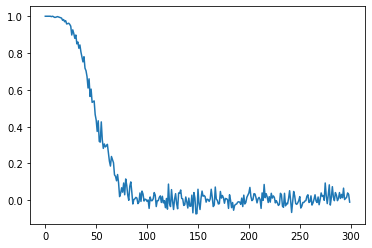

In [5]:
plt.plot(cost_track)